# Sentiment Identification 

BACKGROUND: A large multinational corporation is seeking to automatically identify the sentiment that their customer base
    talks about on social media. They would like to expand this capability into multiple languages. Many 3rd party tools
    exist for sentiment analysis; however, they need help with under-resourced languages. 

GOAL: Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided documents. Your goal is to
    maximize accuracy. There is special interest in being able to accurately detect negative sentiment. The training data 
    includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently labeled.



In [1]:
import pandas as pd
import regex as re
from cleantext import clean
import emoji
from matplotlib.pyplot import plot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

### Read data

In [3]:
df = pd.read_csv("./roman+urdu+data+set/Roman Urdu DataSet.csv",header=None, usecols=[0,1], names=["text","Sentiment"])

In [4]:
df.head(n=10)

,text,Sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive
5,Wah kya baat likhi,Positive
6,Wha Itni sari khubiya,Positive
7,Itni khubiya,Positive
8,Ya allah rehm farma hm sab pe or zalimo ko hidayat de ameen,Positive
9,Please Everyone AllAh S.w.T ka naam hAmesha Bary Lawzo main Likha kary Wo he Zaat sUb say Bari Hey,Positive


### Data Preprocessing

In [5]:
df.shape

(20229, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20229 entries, 0 to 20228
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       20228 non-null  object
 1   Sentiment  20229 non-null  object
dtypes: object(2)
memory usage: 316.2+ KB


It is observed that there is one null value for text in this dataframe. We will remove this row after cleaning the text. 

After reviewing the data closely, I observed the following. 
1.	English sentences
2.	English words intermixed with urdu
3.	Characters ðŸ˜, Emojis
4.	Different spellings for same word- aunty vs anty vs Aunti
5.	Colloquial language in English mixed in
6.	Short forms- Mbrk for Mubarak
7.	Unnecessary punctuation- ,,,
8.	  😊 is noted as negative- Row 10595
9.	 “ Hahaha… so true “ is noted as negative- Row 10597 
10.	 Row 10615 : Well done hahaha is noted as negative. This is incorrect.
11.	Many words are not spelled correctly. “har” is hr (meaning "all"), "bat" (pronounced as bhath, meaning "talk") appears as both "bat"(Row 18604) and "bt" (Row 2,3)

We can remove special characters, punctuation, replace emojis with words, convert all words to lower case. Characters repeated 3 times or more are replaced by just two instances. 



In [7]:
def replace_emojis_with_words(text):
    # Emoji replacement dictionary
    emoji_map = {
        r":-?\)": "happy",
        r":-?[dD]": "happy",
        r":-?\(": "sad",
        r":-?[Pp]": "playful",
        r";-?\)": "wink",
        r":'\(": "crying",
        r":-?O": "surprised",
        r":-?o": "surprised",
        r":-?v": "awkward",
        r"<3": "love",
        r"xD": "laughing",
        r"X-D": "laughing",
        r":-?\|": "neutral",
        r"[oO]_[oO]": "shocked",
        r";_;": "crying"
    }
    for pattern, word in emoji_map.items():
        text = re.sub(pattern, word, text, flags=re.IGNORECASE)
    return text


In [8]:
def remove_chars(text, 
                 lower: bool = False, 
                 punct: bool = False):
    return clean(text=text,
            fix_unicode=True,
            to_ascii=True,
            lower=lower,
            no_line_breaks=False,
            no_urls=False,
            no_emails=False,
            no_phone_numbers=False,
            no_numbers=False,
            no_digits=False,
            no_currency_symbols=False,
            no_punct=punct,
            lang="en"
            )

def remove_repeated_chars(text):
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text
def reduce_repeated_syllables(text):
    # Reduce any 3 or more repetitions of a character group to just 2
    return re.sub(r'(\b\w{1,}?)(\1{2,})', r'\1\1', text)


df["cleaned"] = df["text"].apply(remove_chars)
df["cleaned"] = df["cleaned"].apply(replace_emojis_with_words)
df["cleaned"] = df["cleaned"].apply(remove_repeated_chars)
df["cleaned"] = df["cleaned"].apply(reduce_repeated_syllables)
df["cleaned"] = df["cleaned"].apply(remove_chars,lower = True, punct = True)

A quick check to see if cleaning was successful for emojis, punctuations, converting to lower case.

In [9]:
df.iloc[10594,:]

text               :)
Sentiment    Negative
cleaned         happy
Name: 10594, dtype: object

In [10]:
df.iloc[18694,:]

text                 Waqar Khan :p yahan bhi noon league :D
Sentiment                                           Neutral
cleaned      waqar khan playful yahan bhi noon league happy
Name: 18694, dtype: object

In [11]:
df.iloc[2,:]

text         Kya bt hai,
Sentiment       Positive
cleaned       kya bt hai
Name: 2, dtype: object

In [12]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\betti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
def remove_stopwords(text):
    stop_words = ['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 'woh', 'bhi', 'aur', 'wo', 'yeh', 
                  'rha', 'hota', 'ho', 'ga', 'ka', 'le', 'lye', 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya', 
                  'gaya', 'kch', 'ab', 'thy', 'thay', 'houn', 'hain', 'han', 'to', 'is', 'hi', 'jo', 'kya', 'thi', 'se',
                  'pe', 'phr', 'wala', 'waisay', 'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski',
                  'ne', 'haan', 'acha', 'nai', 'sent', 'photo', 'you', 'kafi', 'gai', 'rhy', 'kuch', 'jata', 'aye', 'ya',
                  'dono', 'hoa', 'aese', 'de', 'wohi', 'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna', 'gi',
                  'hova', 'yehi', 'jana', 'jye', 'chal', 'mil', 'tu', 'hum', 'par', 'hay', 'kis', 'sb', 'gy', 'dain', 
                  'krny', 'tou']
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered)
df["cleaned"] = df["cleaned"].apply(remove_stopwords)

In [14]:
#  Drop any rows with missing values
df.dropna(subset=["cleaned", "text","Sentiment"], inplace=True)

In [15]:
df.shape

(20228, 3)

Let us understand the dataset some more. 

In [16]:
df.groupby("Sentiment").count()

,text,cleaned
Sentiment,,
Neative,1,1
Negative,5286,5286
Neutral,8928,8928
Positive,6013,6013


The Sentiment Neative seems to be a typo for Negative. Replacing Neative with Negative.

In [17]:
df.loc[df.Sentiment=="Neative","Sentiment"] = "Negative"

Plot breakdown of sentiment.

<AxesSubplot:title={'center':'Sentiment Count'}, xlabel='Sentiment', ylabel='Count'>

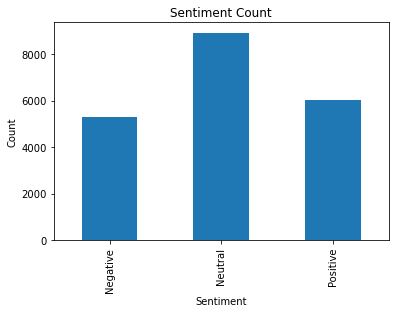

In [18]:
grouped = df.groupby("Sentiment")["text"].count()
grouped.plot(kind='bar', xlabel = "Sentiment", ylabel = "Count", title = "Sentiment Count")


There seems to be a large number of Neutral Sentiment compared to both Positive and Negative. The company would likely
care more about Negative ratings than Neutral or Positive ratings if their goal is to improve customer sentiment towards
them.

### Data Encoding

The Roman Urdu dataset is all text. This needs to be encoded into numerical values. There are only 3 sentiment values and 
they can be encoded using Label Encoder. The text field can be encoded in a number of ways- Count Vectorizer, TF-IDF (Term Frequency Inverse Document Frequency) etc. Neural nets and advanced models such as bert and mbert can be used to encode the entire dataset. 

I will use CountVectorizer and TF-IDF to encode the data. 

In [19]:
le =LabelEncoder()
df["Sentiment_encoded"]=le.fit_transform(df["Sentiment"])

In [57]:
y = df["Sentiment_encoded"]

In [21]:
df[["Sentiment", "Sentiment_encoded"]].drop_duplicates("Sentiment").reset_index()

,index,Sentiment,Sentiment_encoded
0,0,Positive,2
1,3762,Neutral,1
2,10100,Negative,0


Negative sentiment is encoded as 0, Neutral as 1, Positive as 2

### Build model

It is important to split the data into test and training set to measure the performance of the models. The problem states that accuracy is the benchmark. Accuracy will need to be measured on the test set. 

In [58]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df["cleaned"])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

We can start with Logistic Regression and Naive Bayes, both commonly used for text classification. 

#### Logistic Regression

In [24]:
lr = LogisticRegression(random_state=10, max_iter= 1000, solver="saga", class_weight="balanced", multi_class="multinomial")  
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [25]:
#tf-idf + LR
print("Accuracy_score" ,accuracy_score(y_test, y_pred))

Accuracy_score 0.6260504201680672


In [26]:
pipeline = Pipeline([
    ('clf', LogisticRegression(random_state=10, solver="saga", class_weight="balanced", l1_ratio = 0.5, multi_class="multinomial"))  # logistic regression model
])
param_grid = {
    'clf__C': [0.1, 1, 5, 10],  # Regularization strength
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Predict on test set
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\betti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best Parameters: {'clf__C': 1, 'clf__penalty': 'l2'}
Best Cross-Validation Accuracy: 0.6441732509576197
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1080
           1       0.64      0.69      0.67      1720
           2       0.66      0.61      0.63      1246

    accuracy                           0.63      4046
   macro avg       0.62      0.61      0.62      4046
weighted avg       0.63      0.63      0.63      4046



### Naive Bayes

In [27]:
from sklearn.naive_bayes import MultinomialNB

In [28]:
mnb = MultinomialNB()

In [29]:
x_train = X_train.toarray()
x_test = X_test.toarray()
#Train the model using the training sets
mnb.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = mnb.predict(x_test)

In [30]:
print("Accuracy_score" ,accuracy_score(y_test, y_pred))

Accuracy_score 0.5949085516559565


### Support Vector Machine

In [60]:
# Train SVM classifier
svm_classifier = SVC(class_weight = "balanced")
svm_classifier.fit(X_train, y_train)

SVC(class_weight='balanced')

In [61]:
y_pred = svm_classifier.predict(X_test)
print("Accuracy_score" ,accuracy_score(y_test, y_pred))

Accuracy_score 0.6248146317350469


### Count Vectorizer

In [33]:
cv = CountVectorizer()
X = cv.fit_transform(df["cleaned"])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
pipeline = Pipeline([
    ('clf', LogisticRegression(random_state=10, solver="saga", class_weight="balanced", l1_ratio = 0.5, multi_class="multinomial"))  # logistic regression model
])
param_grid = {
    'clf__C': [0.1, 1, 5, 10],  # Regularization strength
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Predict on test set
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\betti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best Parameters: {'clf__C': 5, 'clf__penalty': 'l2'}
Best Cross-Validation Accuracy: 0.6504768145511589
              precision    recall  f1-score   support

           0       0.59      0.54      0.56      1080
           1       0.65      0.73      0.68      1720
           2       0.66      0.60      0.63      1246

    accuracy                           0.64      4046
   macro avg       0.63      0.62      0.63      4046
weighted avg       0.64      0.64      0.64      4046



C:\Users\betti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Having tried multiple machine learning models including the three showcased in this notebook, I find that Logistic Regression gave the best accuracy without hyperparameter tuning. The hyperparameter tuning gives slightly better results. Using CountVectorizer instead of TF-IDF gives slightly better accuracy as well. For SVM and Naive Bayes, one can do hyperparameter tuning to get some improvement in accuracies. I am choosing TF-IDF + Logistic Regression moving forward.

## Binary Classification

Given that the company would be most interested in the negative reviews, one could
1. use just Positive and Negative reviews since the numbers for both are comparable to each other.
2. Combine the Positive and neutral ratings into one category and do a binary classification vs the Negative ratings.

I will test out a simple Logistic Regression for both scenarios.

### Use only Positive and Negative reviews

In [35]:
df_pn = df.loc[((df.Sentiment == "Positive") | (df.Sentiment == "Negative"))]

In [36]:
df_pn.shape

(11300, 4)

In [37]:
df_pn.head()

,text,Sentiment,cleaned,Sentiment_encoded
0,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive,sai kha her kisi kay bus bat nhi lakin hal kal bi aj aj bi sirf aus say bus,2
1,sahi bt h,Positive,sahi bt h,2
2,"Kya bt hai,",Positive,bt,2
3,Wah je wah,Positive,wah je wah,2
4,Are wha kaya bat hai,Positive,are wha kaya bat,2


In [38]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_pn["cleaned"])

In [39]:
y = df_pn["Sentiment_encoded"]

In [40]:
df_pn.groupby("Sentiment_encoded").count()

,text,Sentiment,cleaned
Sentiment_encoded,,,
0,5287,5287,5287
2,6013,6013,6013


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [42]:
lr = LogisticRegression(random_state=10, max_iter= 1000, solver="saga", class_weight="balanced", multi_class="multinomial")  
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy_score" ,accuracy_score(y_test, y_pred))

Accuracy_score 0.772566371681416


Just weeding out the Neutral sentiment caused the accuracy to jump to 77% from 64%. 

### Combine Positive and Neutral reviews 

In [43]:
df_posneu_neg = df

In [44]:
# Create a new column based on a custom function
df_posneu_neg['PN_Neg'] = df.apply(lambda row: 2 if row['Sentiment_encoded'] >= 1 else 0, axis=1)


In [45]:
df_posneu_neg.groupby("PN_Neg").count()

,text,Sentiment,cleaned,Sentiment_encoded
PN_Neg,,,,
0,5287,5287,5287,5287
2,14941,14941,14941,14941


In [46]:
y = df_posneu_neg["PN_Neg"]

In [47]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_posneu_neg["cleaned"])


In [48]:
X.shape

(20228, 32840)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [50]:
lr = LogisticRegression(random_state=10, max_iter= 1000, solver="saga", class_weight="balanced", multi_class="multinomial")  
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy_score" ,accuracy_score(y_test, y_pred))

Accuracy_score 0.764211566979733


By combining positive and neutral sentiment into one, we again observe a jump in accuracy to 76.4%. This is slightly lower 
than the accuracy obtained by using only positive and negative sentiment (77.25%).

It needs to be noted that each of these instances, we can do hyperparameter tuning for slightly better results.